In [1]:
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math, Latex
import handcalcs.render
from handcalcs import handcalc
from scipy.stats import norm

sys.path.append('../src')
from pmule import PredecessorTable, ProjectGraph, EarnedValue, pinta_tikz, plot_cargas, plot_curvas_valor_ganado

# Enunciado

Considere el proyecto cuya información se adjunta y realice los siguientes apartados.

In [2]:
periodo_a_probabilidad_normal = 10
periodo_b_probabilidad_normal = 18
probabilidad_exito_normal = 0.85

periodo_a_probabilidad_montecarlo = 13
periodo_b_probabilidad_montecarlo = 18
probabilidad_exito_montecarlo = 0.85

pregunta_1 = Markdown( "1. Indique el coste de realización del proyecto para la duración inicialmente planificada")
pregunta_2 = Markdown( "2. Dibuje el grafo Pert y Roy del proyecto. Utilizando las duraciones medias de las actividades, determine el camino crítico e indique el calendario de ejecución de las actividades.  ")
pregunta_3 = Markdown(f"""3. Utilizando el método de aproximación a la normal:  
                        - determine la probabilidad de terminar antes de {periodo_a_probabilidad_normal} periodos.  
                        - ¿cuál es la duración del proyecto para la cual podemos esperar que el proyecto finalice antes de esa fecha con un {probabilidad_exito_normal*100}% de probabilidad?""")
pregunta_4 = Markdown(f"""4. Utilizando el método de MonteCarlo:  
                        - determine la duración media y desviación típica de la duración del proyecto.  
                        - determine la probabilidad de que el proyecto finalice en menos de {periodo_a_probabilidad_montecarlo} periodos.  
                        - determine la duración del proyecto para la cual podemos esperar que el proyecto finalice antes de esa fecha con un {probabilidad_exito_montecarlo*100}% de probabilidad?.  """)



In [3]:
for item in dir():
    if item.startswith('pregunta_'):
        display(eval(item))

1. Indique el coste de realización del proyecto para la duración inicialmente planificada

2. Dibuje el grafo Pert y Roy del proyecto. Utilizando las duraciones medias de las actividades, determine el camino crítico e indique el calendario de ejecución de las actividades.  

3. Utilizando el método de aproximación a la normal:  
                        - determine la probabilidad de terminar antes de 10 periodos.  
                        - ¿cuál es la duración del proyecto para la cual podemos esperar que el proyecto finalice antes de esa fecha con un 85.0% de probabilidad?

4. Utilizando el método de MonteCarlo:  
                        - determine la duración media y desviación típica de la duración del proyecto.  
                        - determine la probabilidad de que el proyecto finalice en menos de 13 periodos.  
                        - determine la duración del proyecto para la cual podemos esperar que el proyecto finalice antes de esa fecha con un 85.0% de probabilidad?.  

In [4]:
%%capture
%mkdir -p ~/temp 
%cd ~/temp

In [5]:
#| tbl-cap: "Cuadro de datos del enunciado del ejercicio"
#| label: tbl-datosEnunciado

import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, b, m, a, BAC, coste_duracion_tope, duracion_tope, duracionReal, AC, PorcentajeRealizado, recursos
     ('A', '---  ',   6,  2.5, 2,      1600, 1800, 2, 5, 1800, 100, 5 ),
     ('B', '---  ',   4,    3, 2,      2900, 3100, 1, 3, 3200, 100, 5 ),
     ('C', '---  ',   3,    2, 1,       600,  800, 1, 2,  550, 100, 5 ),
     ('D', 'B    ',   3,    2, 1,       600,  700, 1, 1,  540, 100, 10 ),
     ('E', 'D,C  ',   7,    5, 3,      1600, 2200, 2, 5,  750,  50, 5 ),
     ('F', 'A,D,C',   4,    3, 2,      2000, 2800, 2, 4,  500,  40, 5 ),
     ('G', 'D,C  ',   6,  1.25, 1,       600,  700, 1, 5,  200,  50, 10 ),
     ('H', 'F,E,G',  10,    8, 6,       3500, 4900, 3, 0,    0,   0, 5 ),
     ('I', 'E,G  ',   8,    7, 6,       3700, 4300, 4, 0,    0,   0, 5 ),

] ,columns=['activity', 'predecessors', 'b', 'm', 'a',
            'BAC', 'cost_cap_duration', 'cap_duration', 'actual_duration', 'AC', 'performed', 'resources']).set_index('activity')

datos_enunciado['b'] = datos_enunciado['b'].astype(int)
datos_enunciado

,predecessors,b,m,a,BAC,cost_cap_duration,cap_duration,actual_duration,AC,performed,resources
activity,,,,,,,,,,,
A,---,6,2.50,2,1600,1800,2,5,1800,100,5
B,---,4,3.00,2,2900,3100,1,3,3200,100,5
C,---,3,2.00,1,600,800,1,2,550,100,5
D,B,3,2.00,1,600,700,1,1,540,100,10
E,"D,C",7,5.00,3,1600,2200,2,5,750,50,5
F,"A,D,C",4,3.00,2,2000,2800,2,4,500,40,5
G,"D,C",6,1.25,1,600,700,1,5,200,50,10
H,"F,E,G",10,8.00,6,3500,4900,3,0,0,0,5
I,"E,G",8,7.00,6,3700,4300,4,0,0,0,5


{{< pagebreak >}}

# Solución

## Parte 1. Análisis desde el origen hasta el presente.

### Apartado 1

In [6]:
display(pregunta_1)

1. Indique el coste de realización del proyecto para la duración inicialmente planificada

Para responder este apartado tan sólo es necesario sumar los costes indicados en la columna relativa al coste inicialmente planificado (BAC).

In [7]:
Markdown(f"La suma de los costes es {int(datos_enunciado['BAC'].sum())}")

La suma de los costes es 17100

### Apartado 2

In [8]:
display(pregunta_2)

2. Dibuje el grafo Pert y Roy del proyecto. Utilizando las duraciones medias de las actividades, determine el camino crítico e indique el calendario de ejecución de las actividades.  

##### Precálculo de la duración media de las actividades, desviación típica, y coste unitario de reducción.

Es conveniente realizar el cálculo de los valores que vamos a necesitar en diferentes apartados:  
- duración media de las actividades  
- desviación estándar de la duración de las actividades  
- varianza de la duración de las actividades  
- coste unitario de reducción.  

In [9]:
#| tbl-cap: "Cálculo de la duración media, desviación típica, varianza, y coste unitario de reducción."
#| label: tbl-calculosInteresantes
datos_proyecto = datos_enunciado.copy()
datos_proyecto['duration'] = datos_proyecto.eval('(b + 4*m +a)/6')
datos_proyecto['standard_deviation'] = datos_proyecto.eval('(b -a)/6')
datos_proyecto['variance'] = datos_proyecto['standard_deviation']**2
datos_proyecto['ucr'] = datos_proyecto.eval('(cost_cap_duration - BAC)/(duration - cap_duration)').round(2)
datos_proyecto[['b', 'm', 'a', 'duration', 'standard_deviation', 'variance', 'ucr']]

,b,m,a,duration,standard_deviation,variance,ucr
activity,,,,,,,
A,6,2.50,2,3.0,0.666667,0.444444,200.0
B,4,3.00,2,3.0,0.333333,0.111111,100.0
C,3,2.00,1,2.0,0.333333,0.111111,200.0
D,3,2.00,1,2.0,0.333333,0.111111,100.0
E,7,5.00,3,5.0,0.666667,0.444444,200.0
F,4,3.00,2,3.0,0.333333,0.111111,800.0
G,6,1.25,1,2.0,0.833333,0.694444,100.0
H,10,8.00,6,8.0,0.666667,0.444444,280.0
I,8,7.00,6,7.0,0.333333,0.111111,200.0


Con esta información podemos completar el cuadro de datos del enunciado

In [10]:
#| tbl-cap: "Datos del proyecto."
#| label: tbl-DatosProyectoComplementados
datos_proyecto

,predecessors,b,m,a,BAC,cost_cap_duration,cap_duration,actual_duration,AC,performed,resources,duration,standard_deviation,variance,ucr
activity,,,,,,,,,,,,,,,
A,---,6,2.50,2,1600,1800,2,5,1800,100,5,3.0,0.666667,0.444444,200.0
B,---,4,3.00,2,2900,3100,1,3,3200,100,5,3.0,0.333333,0.111111,100.0
C,---,3,2.00,1,600,800,1,2,550,100,5,2.0,0.333333,0.111111,200.0
D,B,3,2.00,1,600,700,1,1,540,100,10,2.0,0.333333,0.111111,100.0
E,"D,C",7,5.00,3,1600,2200,2,5,750,50,5,5.0,0.666667,0.444444,200.0
F,"A,D,C",4,3.00,2,2000,2800,2,4,500,40,5,3.0,0.333333,0.111111,800.0
G,"D,C",6,1.25,1,600,700,1,5,200,50,10,2.0,0.833333,0.694444,100.0
H,"F,E,G",10,8.00,6,3500,4900,3,0,0,0,5,8.0,0.666667,0.444444,280.0
I,"E,G",8,7.00,6,3700,4300,4,0,0,0,5,7.0,0.333333,0.111111,200.0


#### Cuadros de prelaciones expandido

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.

In [11]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessors')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I
activities,,,,,,,,,
A,,,,,,,,,
B,,,,,,,,,
C,,,,,,,,,
D,,True,,,,,,,
E,,,True,True,,,,,
F,True,,True,True,,,,,
G,,,True,True,,,,,
H,,,,,True,True,True,,
I,,,,,True,,True,,


{{< pagebreak >}}

#### Dibuje el diagrama de Gantt del proyecto planificado

In [12]:

prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessors')
prelaciones.display_immediate_linkage_matrix()
proyecto = prelaciones.create_project()

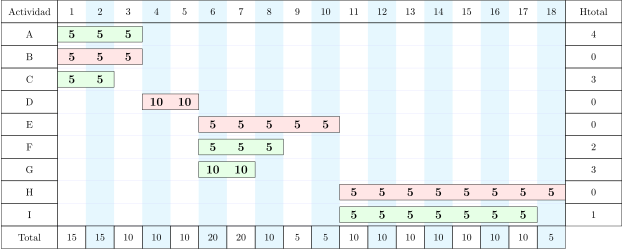

In [13]:
#| fig-cap: "Diagrama de Gantt del proyecto en su estado inicial"
#| label: fig-GanttInicial
gantt, dibujo = proyecto.gantt(datos_proyecto,
                          'duration',
                          'resources',
                          total='fila',
                          holguras=True,
                          tikz=True, 
                          params=dict(
                             period_width=1
                          ),
              )
pinta_tikz(dibujo)

{{< pagebreak >}}

#### Grafo PERT con numeración de nodos

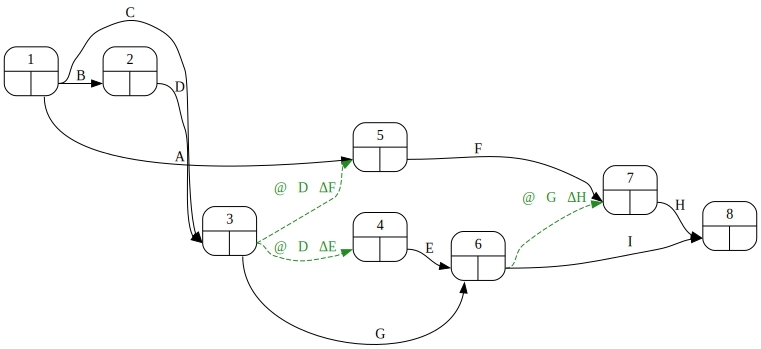

In [14]:
#| fig-cap: "Grafo Pert con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto.pert()

#### Grafo Roy

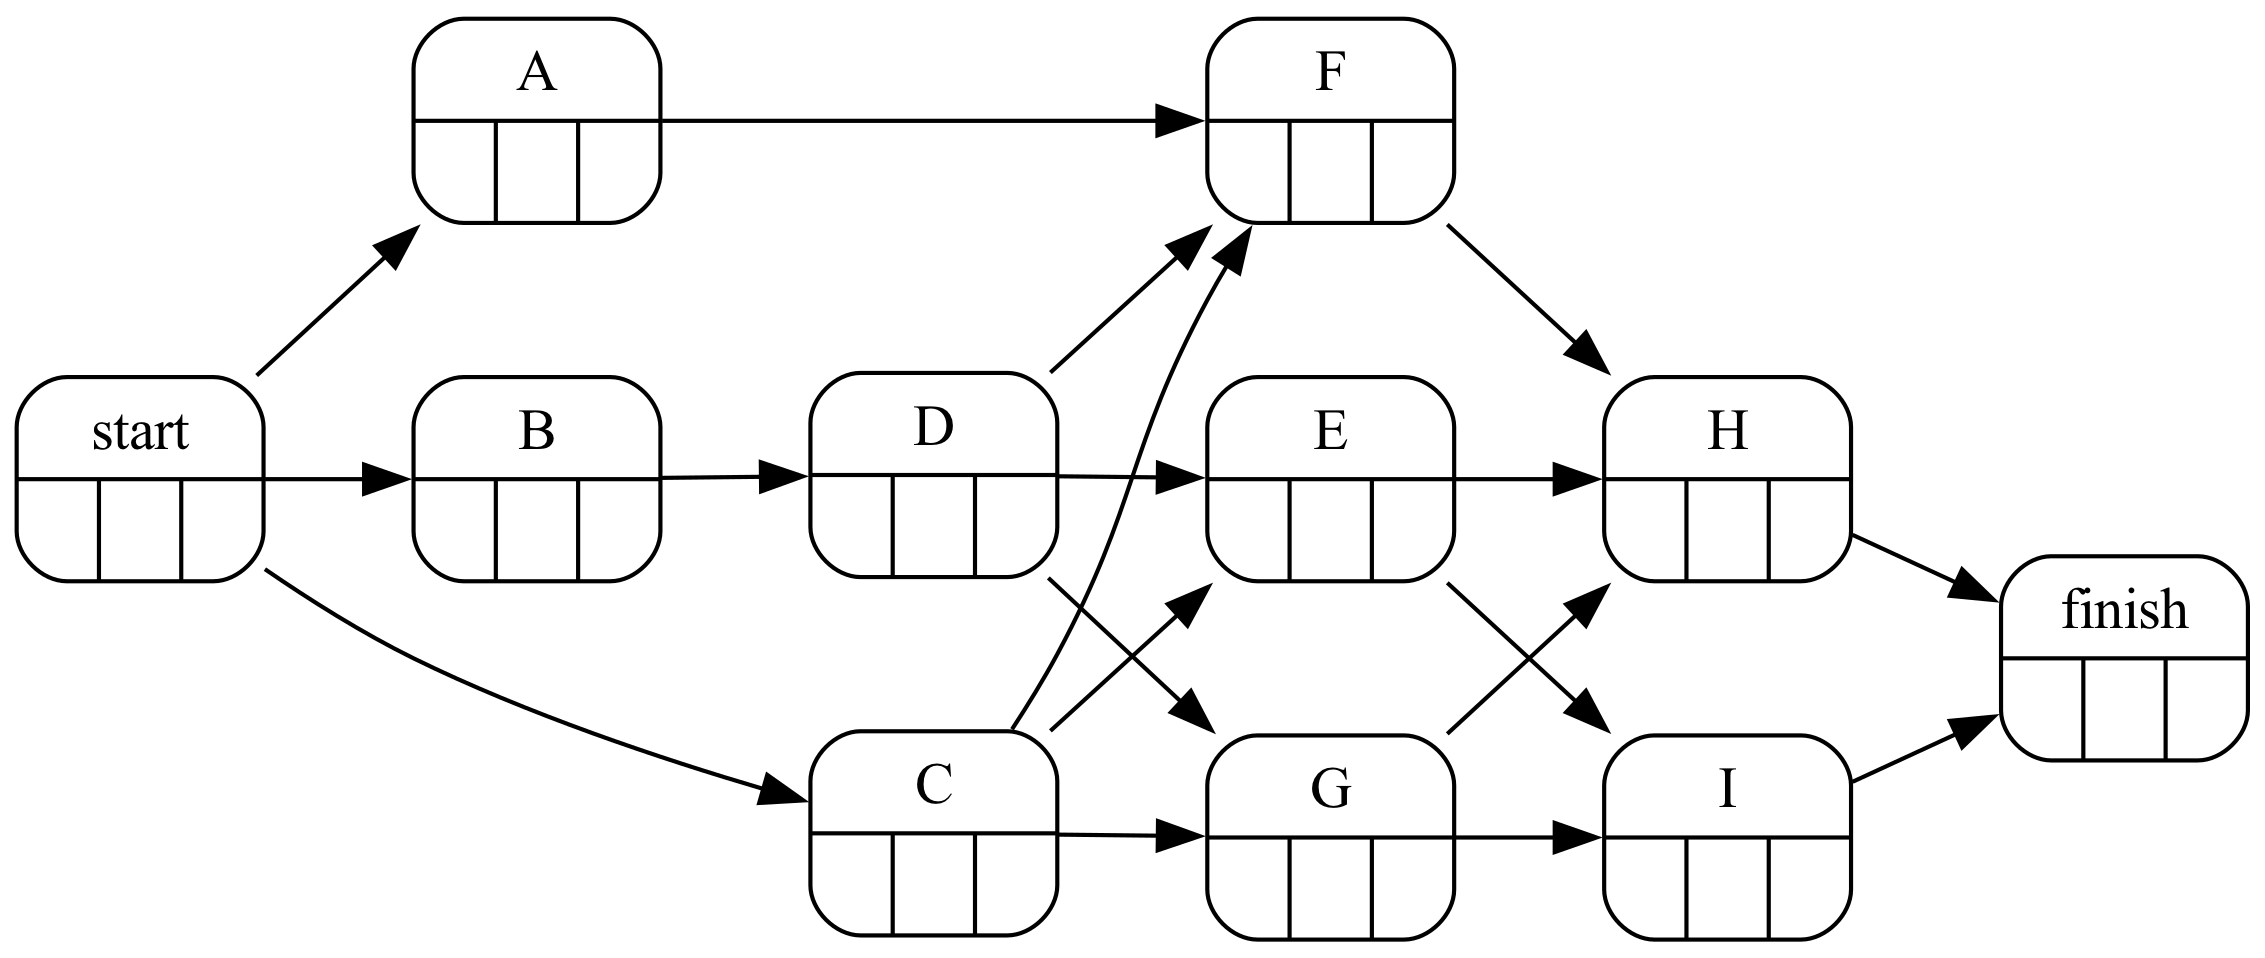

In [15]:
#| fig-cap: "Grafo Roy con indicación de los números de nodos"
#| label: fig-RoyNumeracionNodos
proyecto.roy()

#### Matriz de Zaderenko
A continuación podemos determinar la duración del proyecto calculando los tiempos tempranos y tardíos de su grafo Pert. Se hace en este caso mediante el algoritmo de Zaderenko:

In [16]:
#| tbl-cap: "Matriz de Zaderenko para el cálculo de tiempos tempranos y tardíos"
#| label: tbl-Zaderenko
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,early
1,,3.0,2.0,,3.0,,,,0.0
2,,,2.0,,,,,,3.0
3,,,,0.0,0.0,2.0,,,5.0
4,,,,,,5.0,,,5.0
5,,,,,,,3.0,,5.0
6,,,,,,,0.0,7.0,10.0
7,,,,,,,,8.0,10.0
8,,,,,,,,,18.0
late,0.0,3.0,5.0,5.0,7.0,10.0,10.0,18.0,


Los tiempos tempranos y tardíos obtenidos para cada nodo son:

In [17]:
#| tbl-cap: "Valores de los tiempos tempranos y tardíos de los nodos"
#| label: tbl-TempranosTardios
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,3,3
3,5,5
4,5,5
5,5,7
6,10,10
7,10,10
8,18,18


#### Holgura total de las actividades
Conocidos los tiempos tempranos y tardíos se puede proceder a calcular la holgura total de las actividades.

In [18]:
#| tbl-cap: "Holgura total de las actividades"
#| label: tbl-holguras
resultados_pert['activities']

,H_total
@∇D⤑ΔE,0
@∇D⤑ΔF,2
@∇G⤑ΔH,0
A,4
B,0
C,3
D,0
E,0
F,2
G,3


#### Camino crítico
Las actividades con holgura total cero forman el camino crítico. Según el grafo Pert del proyecto, éste está compuesto por las siguientes rutas, cuyas actividades se listan en orden alfabético:

In [19]:
proyecto.display_critical_path(datos_proyecto['duration'])

- Route_2 :	B, D, E, H <br> 

#### Grafo PERT con indicación de tiempos, y rutas del camino crítico

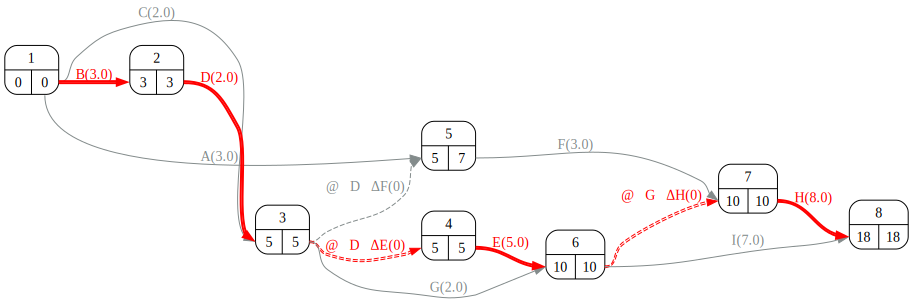

In [20]:
#| fig-cap: "Grafo Pert del proyecto con indicación del camino crítico"
#| label: fig-pertCritico
proyecto.pert(durations=datos_proyecto['duration'])

#### Grafo Roy con indicación de tiempos, y rutas del camino crítico

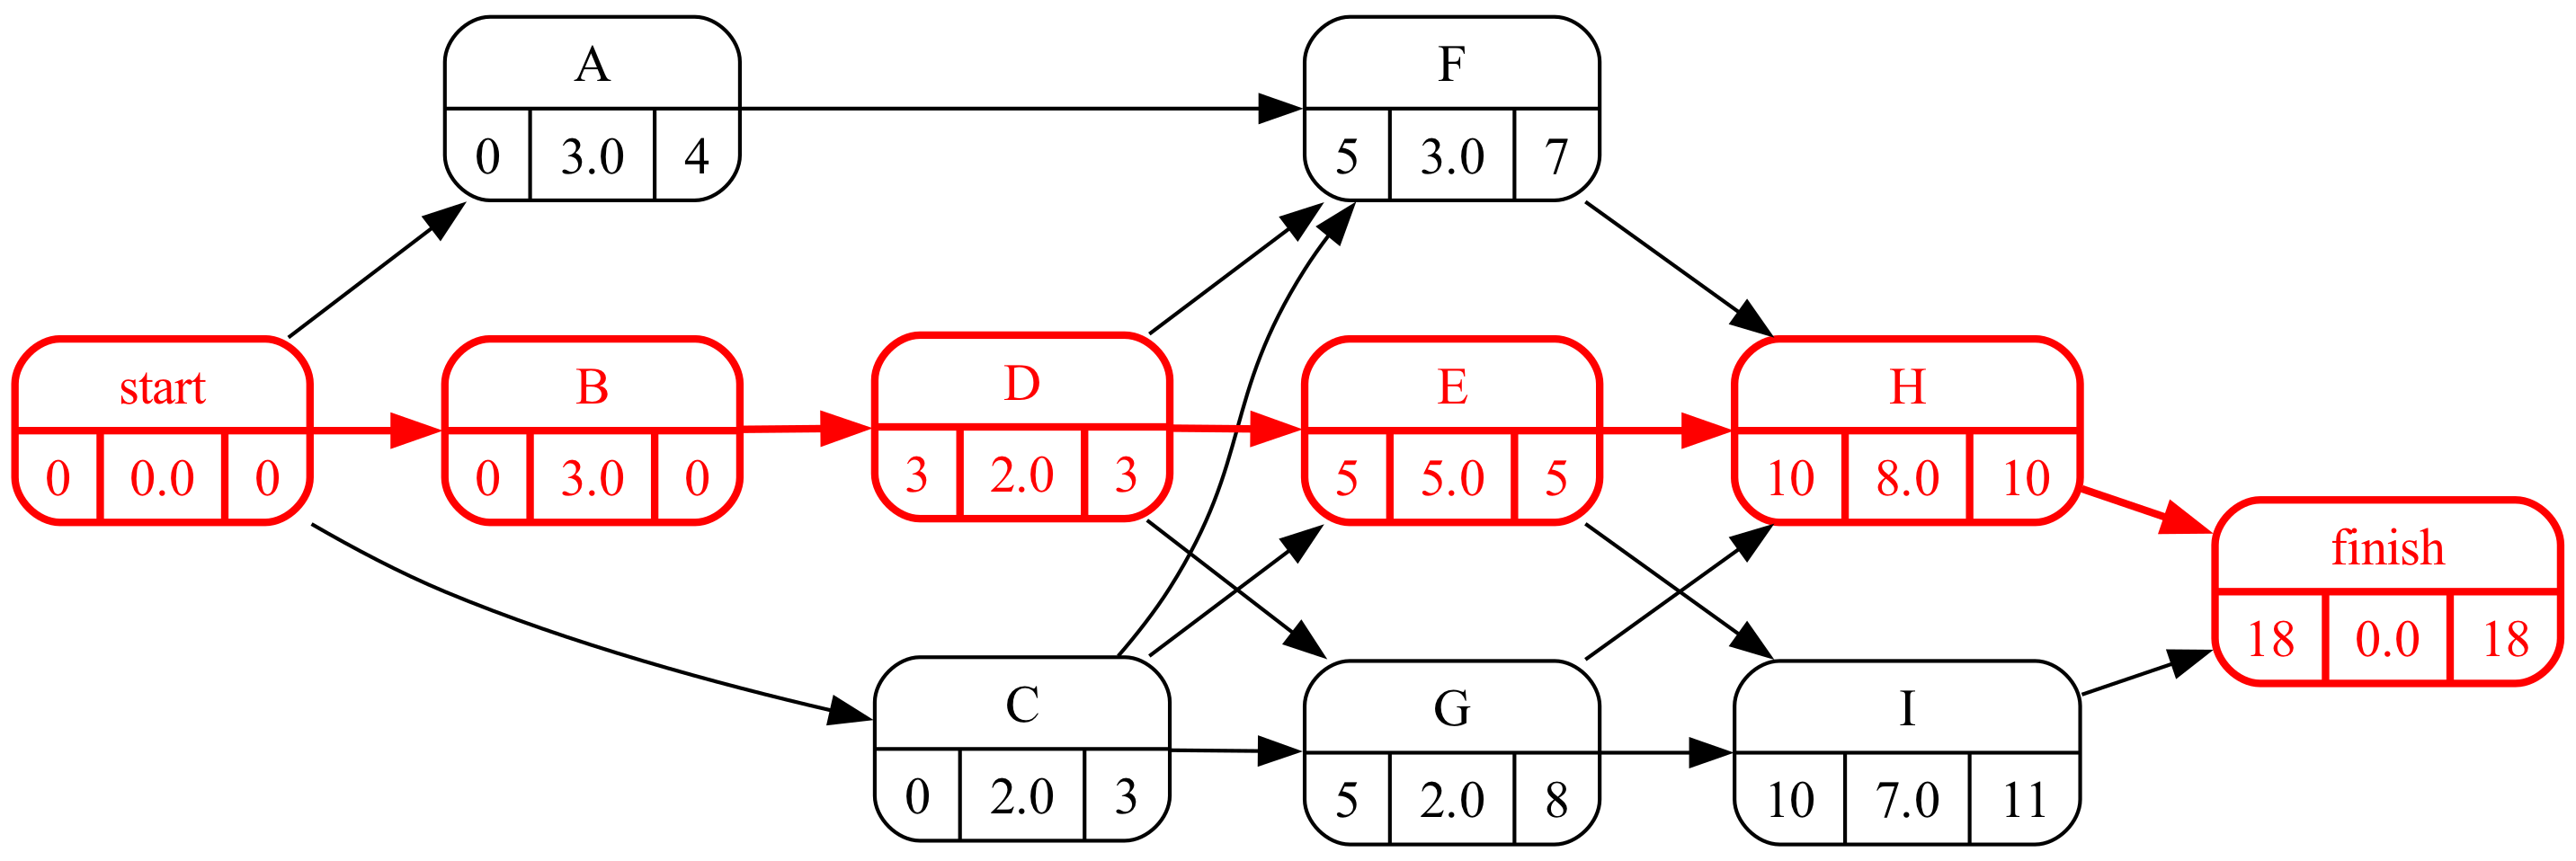

In [21]:
#| fig-cap: "Grafo Roy del proyecto con indicación del camino crítico"
#| label: fig-royCritico
proyecto.roy(durations=datos_proyecto['duration'])

#### Calendario del proyecto
Se muestra a continuación el calendario del proyecto con indicación de las fechas de inicio y fin más tempranas y tardías de cada actividad:

In [22]:
#| tbl-cap: "Calendario del proyecto"
#| label: tbl-calendario
duration_label='duration'
calendario = proyecto.calendar(datos_proyecto[duration_label]).drop(columns='duracion').rename(columns={'inicio_mas_temprano':'Inicio más temprano',
                                                                    'inicio_mas_tardio':'Inicio más tardio',
                                                                    'fin_mas_temprano':'Fin más temprano',
                                                                    'fin_mas_tardio':'Fin más tardio',
                                                                    'H_total': 'Holgura total'
                                                                   })
calendario

,Inicio más temprano,Inicio más tardio,Fin más temprano,Fin más tardio,Holgura total
activity,,,,,
A,0,4,3,7,4
B,0,0,3,3,0
C,0,3,2,5,3
D,3,3,5,5,0
E,5,5,10,10,0
F,5,7,8,10,2
G,5,8,7,10,3
H,10,10,18,18,0
I,10,11,17,18,1


{{< pagebreak >}}

## Apartado 3

In [23]:
display(pregunta_3)

3. Utilizando el método de aproximación a la normal:  
                        - determine la probabilidad de terminar antes de 10 periodos.  
                        - ¿cuál es la duración del proyecto para la cual podemos esperar que el proyecto finalice antes de esa fecha con un 85.0% de probabilidad?

##### Cálculo de la media de la duración del proyecto

In [24]:
duraciones_medias = datos_proyecto['duration']
duracion_media_proyecto = int(proyecto.duration(durations=duraciones_medias))

La duración media del proyecto la tenemos ya calculada al haber calculado el calendario de ejecución del proyecto para duraciones medias de las actividades.

In [25]:
Markdown(f"La duración media del proyecto es {duracion_media_proyecto} periodos")

La duración media del proyecto es 18 periodos

##### Cálculo de la desviación típica del proyecto

Calculamos la varianza para cada rama como el máximo valor de las varianzas de las rutas del camino crítico.

In [26]:
desviacion_proyecto, varianza_caminos = proyecto.standard_deviation(durations = datos_proyecto['duration'],
                                                  variances = datos_proyecto['variance'])
varianza_caminos

,Activities,Variance
Route_2,"B, D, E, H",1.11


In [27]:
Markdown(f"La desviación típica de la duración del proyecto es la máxima desviación típica de todas las rutas críticas. Para este proyecto, haciendo la raíz cuadrada del valor de la varianza, tenemos el valor de desviación típica  {round(desviacion_proyecto,2)}.  ")

La desviación típica de la duración del proyecto es la máxima desviación típica de todas las rutas críticas. Para este proyecto, haciendo la raíz cuadrada del valor de la varianza, tenemos el valor de desviación típica  1.05.  

#### Calculo de la probabilidad de que el proyecto finalice antes del periodo indicado

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad:

In [28]:
probability_TLC = norm.cdf(periodo_a_probabilidad_normal, loc=duracion_media_proyecto, scale=desviacion_proyecto)
Markdown(f"""Utilizando, por ejemplo, una calculadora, para un proyecto con:  
                - duración media {duracion_media_proyecto} y  
                - desviación típica {round(desviacion_proyecto, 2)}  
**el valor de la probabilidad** de que el proyecto finalice antes de {periodo_a_probabilidad_normal} periodos **es {round(probability_TLC * 100, 2)} por ciento**.""")

Utilizando, por ejemplo, una calculadora, para un proyecto con:  
                - duración media 18 y  
                - desviación típica 1.05  
**el valor de la probabilidad** de que el proyecto finalice antes de 10 periodos **es 0.0 por ciento**.

#### Cálculo de la duración del proyecto para la cual se espera que el proyecto haya finalizado antes de esa fecha con la probabilidad requerida

In [29]:
fecha_exito_normal = round(norm.ppf(probabilidad_exito_normal, loc=duracion_media_proyecto, scale=desviacion_proyecto), 1)
Markdown(f"Con una calculadora, por ejemplo, obtenemos que el número de periodos necesarios para alcanzar una tasa de éxito del {probabilidad_exito_normal*100} por ciento es {fecha_exito_normal} periodos.  ")

Con una calculadora, por ejemplo, obtenemos que el número de periodos necesarios para alcanzar una tasa de éxito del 85.0 por ciento es 19.1 periodos.  

{{< pagebreak >}}

## Apartado 4

In [30]:
display(pregunta_4)

4. Utilizando el método de MonteCarlo:  
                        - determine la duración media y desviación típica de la duración del proyecto.  
                        - determine la probabilidad de que el proyecto finalice en menos de 13 periodos.  
                        - determine la duración del proyecto para la cual podemos esperar que el proyecto finalice antes de esa fecha con un 85.0% de probabilidad?.  

In [31]:
num_of_samples = 100000

names_of_the_tasks = datos_proyecto.index
np.random.seed(2025)
durations_montecarlo = pd.DataFrame([np.random.normal(size = num_of_samples,
                                                       loc  = datos_proyecto.duration[task],
                                                       scale= datos_proyecto.standard_deviation[task])
                                      for task in names_of_the_tasks],
                                     index=names_of_the_tasks).T.round(1)

In [32]:
durations_montecarlo

activity,A,B,C,D,E,F,G,H,I
0,2.9,2.8,2.4,2.0,6.3,2.8,2.9,9.2,7.1
1,3.5,3.2,1.4,2.2,3.7,3.2,1.6,9.2,7.1
2,2.0,3.1,2.0,2.0,4.6,2.9,2.3,7.1,7.4
3,2.6,2.7,2.4,2.5,4.2,2.7,2.0,9.1,7.7
4,2.9,2.6,2.5,2.0,4.4,3.7,2.7,8.1,6.3
...,...,...,...,...,...,...,...,...,...
99995,3.1,2.5,2.7,1.9,4.8,3.0,2.0,8.6,7.5
99996,2.6,3.0,2.2,2.3,5.4,2.6,3.3,9.1,6.8
99997,4.3,4.0,1.8,2.1,5.4,3.8,1.7,7.9,7.3
99998,2.3,2.8,1.5,2.2,5.3,3.3,0.4,7.8,6.9


### Determinamos la matriz de caminos del proyecto.

In [33]:
path_matrix = proyecto.path_matrix(dummies=False)
proyecto.display_path_matrix(dummies=False)

,A,B,C,D,E,F,G,H,I
Route_1,1,0,0,0,0,1,0,1,0
Route_2,0,1,0,1,1,0,0,1,0
Route_3,0,1,0,1,1,0,0,0,1
Route_4,0,1,0,1,0,1,0,1,0
Route_5,0,1,0,1,0,0,1,1,0
Route_6,0,1,0,1,0,0,1,0,1
Route_7,0,0,1,0,1,0,0,1,0
Route_8,0,0,1,0,1,0,0,0,1
Route_9,0,0,1,0,0,1,0,1,0
Route_10,0,0,1,0,0,0,1,1,0


### Cálculo de la duración del proyecto

In [34]:
paths_durations_per_iteration = durations_montecarlo @ path_matrix.T
paths_durations_per_iteration

,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,Route_7,Route_8,Route_9,Route_10,Route_11
0,14.9,20.3,18.2,16.8,16.9,14.8,17.9,15.8,14.4,14.5,12.4
1,15.9,18.3,16.2,17.8,16.2,14.1,14.3,12.2,13.8,12.2,10.1
2,12.0,16.8,17.1,15.1,14.5,14.8,13.7,14.0,12.0,11.4,11.7
3,14.4,18.5,17.1,17.0,16.3,14.9,15.7,14.3,14.2,13.5,12.1
4,14.7,17.1,15.3,16.4,15.4,13.6,15.0,13.2,14.3,13.3,11.5
...,...,...,...,...,...,...,...,...,...,...,...
99995,14.7,17.8,16.7,16.0,15.0,13.9,16.1,15.0,14.3,13.3,12.2
99996,14.3,19.8,17.5,17.0,17.7,15.4,16.7,14.4,13.9,14.6,12.3
99997,16.0,19.4,18.8,17.8,15.7,15.1,15.1,14.5,13.5,11.4,10.8
99998,13.4,18.1,17.2,16.1,13.2,12.3,14.6,13.7,12.6,9.7,8.8


In [35]:
project_duration_per_iteration = paths_durations_per_iteration.max(axis="columns")
project_duration_per_iteration.T

0        20.3
1        18.3
2        17.1
3        18.5
4        17.1
         ... 
99995    17.8
99996    19.8
99997    19.4
99998    18.1
99999    19.4
Length: 100000, dtype: float64

### Determina la duración media y la desviación típica de la duración del proyecto.

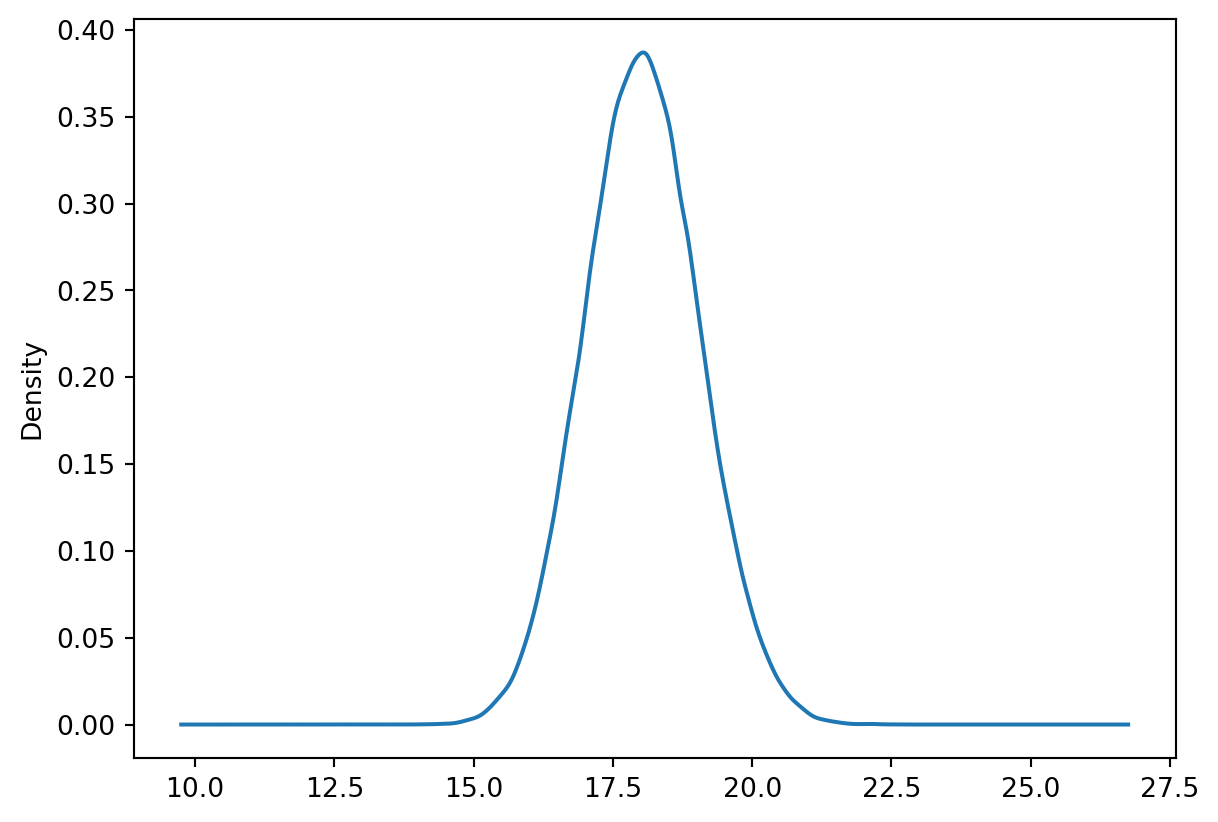

In [36]:
project_duration_per_iteration.plot(kind='density');

In [37]:
project_duration_per_iteration.describe()

count    100000.000000
mean         18.032185
std           1.023811
min          14.000000
25%          17.300000
50%          18.000000
75%          18.700000
max          22.500000
dtype: float64

In [38]:
project_mean_duration = project_duration_per_iteration.mean()
project_std_deviation_duration = project_duration_per_iteration.std()

In [39]:
f"La duración media del proyecto es: {project_mean_duration}, la desviación típica de la duración del proyecto es: {project_std_deviation_duration}"

'La duración media del proyecto es: 18.032185000000002, la desviación típica de la duración del proyecto es: 1.023810581922299'

### ¿Cuál es la probabilidad de que el proyecto finalice en menos de 13 periodos de tiempo?

#### Utilizando la distribución normal

In [40]:
period = 13
probability = norm.cdf(period, loc=project_mean_duration, scale=project_std_deviation_duration)
Markdown(f"Para un proyecto con duración media {project_mean_duration} y desviación típica {round(project_std_deviation_duration, 2)} el valor de la probabilidad pedida es {round(probability * 100, 2)} por ciento.")

Para un proyecto con duración media 18.032185000000002 y desviación típica 1.02 el valor de la probabilidad pedida es 0.0 por ciento.

#### Utilizando los valores de Montecarlo

In [41]:
probability_montecarlo = (project_duration_per_iteration <= period).mean()
Markdown(f"Considerando la secuencia de valores obtenidos por el método de MonteCarlo, el valor de la probabilidad pedida es {round(probability_montecarlo * 100, 2)} por ciento.")

Considerando la secuencia de valores obtenidos por el método de MonteCarlo, el valor de la probabilidad pedida es 0.0 por ciento.

### ¿Cuál es la duración del proyecto para la cual podemos garantizar que el proyecto va finalizar antes de esa fecha con un 85% de probabilidad?

#### Utilizando la distribución normal

In [42]:
prob=0.85
norm.ppf(prob, loc=project_mean_duration, scale=project_std_deviation_duration)

np.float64(19.09329647162134)

#### Utilizando los valores de Montecarlo:

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 85% de las muestras.

In [43]:
project_duration_per_iteration.sort_values(ascending=True).iloc[int(prob*num_of_samples)]

np.float64(19.1)

O bien, utilizando la función `quantile`

In [44]:
project_duration_per_iteration.quantile(q=prob, interpolation='higher')

np.float64(19.1)

{{< pagebreak >}}

## Reducción de la duración del proyecto con mínimo incremento de coste: Algoritmo de Ackoff y Sasieni de todo el proyecto

In [45]:
ackoff, best_option, durations, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                                                            min_durations=datos_proyecto['cap_duration'],
                                                            costs=datos_proyecto['ucr'],
                                                            reduction=20)
ackoff

,A,B,C,D,E,F,G,H,I,0,1,2,3,4,5,6,7,8,9,10
Route_1,200.0,,,,,800.0,,280.0,,14.0,14.0,14.0,14.0,14.0,13.0,12.0,11.0,10.0,9.0,8.0
Route_2,,100.0,,100.0,200.0,,,280.0,,18.0,17.0,16.0,15.0,14.0,13.0,12.0,10.0,9.0,8.0,7.0
Route_3,,100.0,,100.0,200.0,,,,200.0,17.0,16.0,15.0,14.0,13.0,13.0,12.0,11.0,10.0,9.0,8.0
Route_4,,100.0,,100.0,,800.0,,280.0,,16.0,15.0,14.0,13.0,13.0,12.0,12.0,11.0,10.0,9.0,8.0
Route_5,,100.0,,100.0,,,100.0,280.0,,15.0,14.0,13.0,12.0,12.0,11.0,11.0,10.0,9.0,8.0,7.0
Route_6,,100.0,,100.0,,,100.0,,200.0,14.0,13.0,12.0,11.0,11.0,11.0,11.0,11.0,10.0,9.0,8.0
Route_7,,,200.0,,200.0,,,280.0,,15.0,15.0,15.0,15.0,14.0,13.0,12.0,10.0,9.0,8.0,7.0
Route_8,,,200.0,,200.0,,,,200.0,14.0,14.0,14.0,14.0,13.0,13.0,12.0,11.0,10.0,9.0,8.0
Route_9,,,200.0,,,800.0,,280.0,,13.0,13.0,13.0,13.0,13.0,12.0,12.0,11.0,10.0,9.0,8.0
Route_10,,,200.0,,,,100.0,280.0,,12.0,12.0,12.0,12.0,12.0,11.0,11.0,10.0,9.0,8.0,7.0


{{< pagebreak >}}

## Nivelación

In [46]:
proyecto_nivelacion = proyecto.copy()

desplazamientos, cuadrados, my_data, gantt_df, dibujo = proyecto_nivelacion.nivelar(data=datos_proyecto,
                           duration_label='duration',
                           resource_label='resources',
                           #report=False,
                           )

In [47]:
cuadrados

,0,1,2,3,4
activity,,,,,
C,2425,2425,2425,2425,
A,2425,2425,2425,2425,2375
G,2375,2375,2375,2375,
F,2375,,,,
I,2375,2375,,,


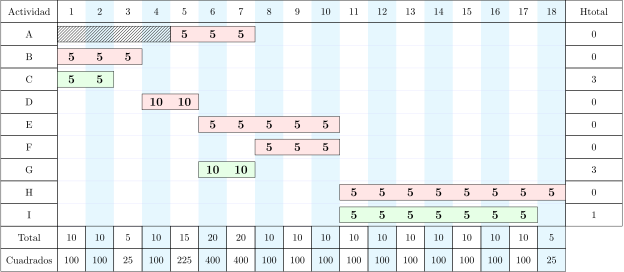

In [48]:
pinta_tikz(dibujo)

{{< pagebreak >}}

## Asignación

##### El número máximo de recursos es 10

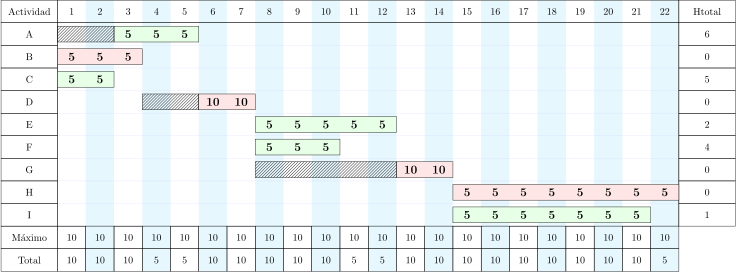

In [49]:
proyecto_asignacion = proyecto.copy()
my_data, gantt_df, dibujo = proyecto_asignacion.asignar(data=datos_proyecto,
                                              duration_label='duration',
                                              resource_label='resources',
                                              maximo = [10],
                                              report = False,
                                              params = dict(
                                                  period_width=1
                                                  )
                                              )
pinta_tikz(dibujo)

{{< pagebreak >}}

## Valor ganado

In [50]:
vg = EarnedValue(proyecto)

gantts = vg.calcula_gantts(datos_proyecto,
                           planned_durations_label='duration',
                           actual_durations_label='actual_duration',
                           PV_label='BAC',
                           AC_label='AC',
                           percentage_complete_label='performed',
                           tikz=True,
                params=dict(
                        period_width=1.5,
                        row_height=0.7,
                        background_horizontal_line_color='black',
                        activity_relative_height=0.6,
                        critical_background_color='white!90!green',
                        regular_background_color='white!90!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        activity_inner_text_style=r"\bfseries\normalsize",),
)

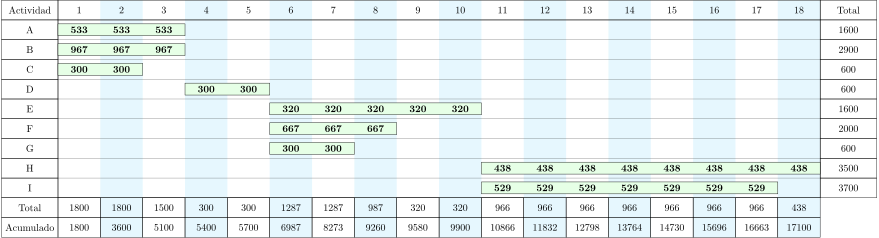

In [51]:
#| out-height: 80%
#| fig-cap: "PV: Valor planificado"

pinta_tikz(gantts['gantt_PV'])

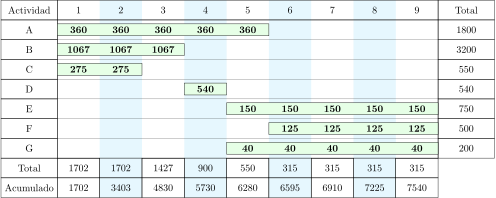

In [52]:
#| out-height: 80%
#| fig-cap: "AC: Coste real"

pinta_tikz(gantts['gantt_AC'])

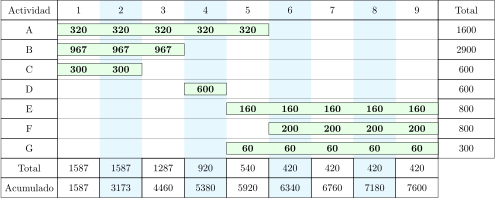

In [53]:
#| out-height: 80%
#| fig-cap: "EV: Valor ganado"

pinta_tikz(gantts['gantt_EV'])

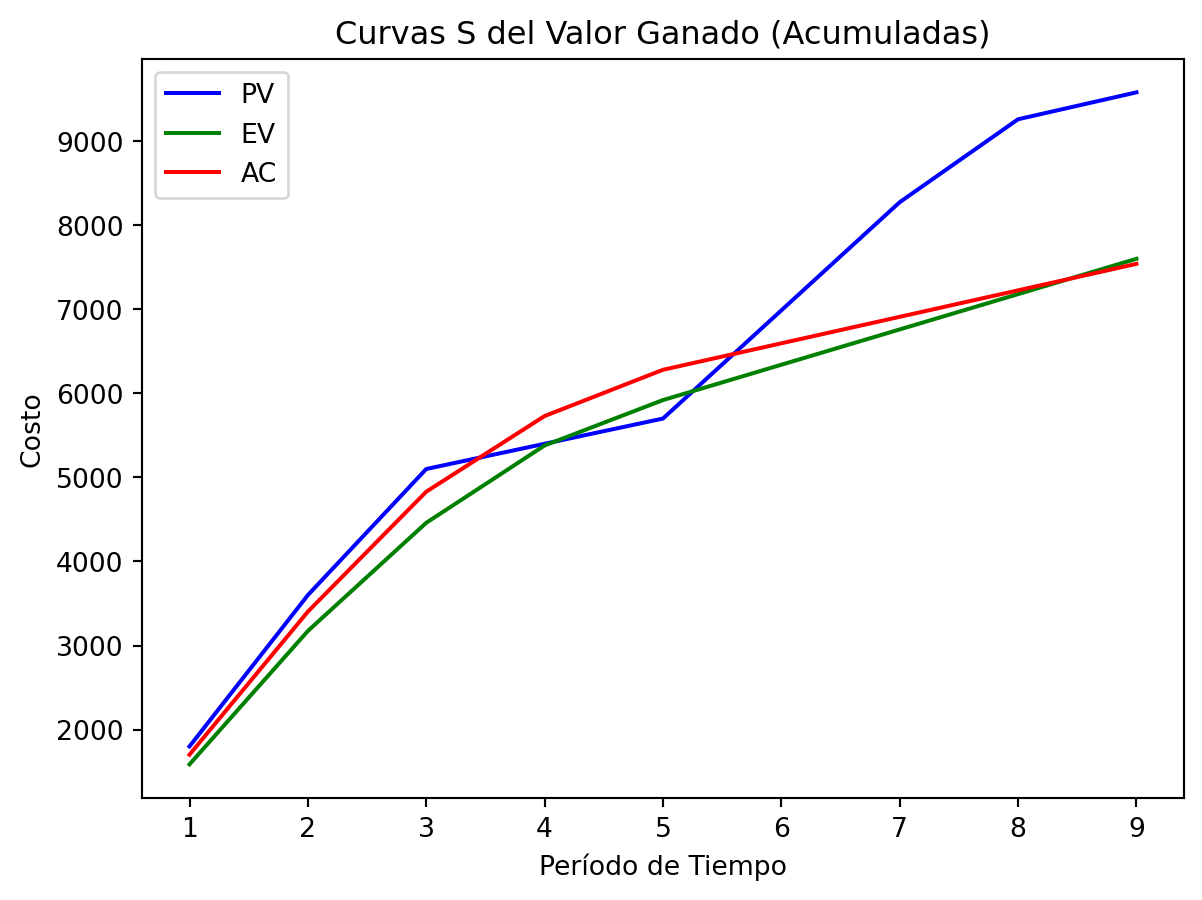

In [54]:
#| out-width: 50%
#| fig-cap: "Evolución en el tiempo de los parámetros del método del valor ganado"
plot_curvas_valor_ganado(gantts)

In [55]:
acumulados = gantts['acumulados']
EV = acumulados.tail(1)['EV'].iloc[0]
AC = acumulados.tail(1)['AC'].iloc[0]
PV = acumulados.tail(1)['PV'].iloc[0]
BAC = round(float(datos_enunciado['BAC'].sum()),2)

In [56]:
Markdown(f"""Utilizando: \\
PV={round(PV,0)} \\
AC={AC} \\
EV={EV} \\
y el BAC={BAC} obtenido sumando los costes planificados, obtenemos:
""")

Utilizando: \
PV=9580.0 \
AC=7540.0 \
EV=7600.0 \
y el BAC=17100.0 obtenido sumando los costes planificados, obtenemos:


In [57]:
from handcalcs.decorator import handcalc

@handcalc(jupyter_display=False) 
def my_calculation(EV,AC,PV,BAC):
    CPI = EV/AC
    SPI = EV/PV
    EAC = BAC / CPI
    CV = EV - AC
    CV_relativo = CV/EV *100
    SV = EV - PV
    SV_relativo = SV/PV *100
    VAC = BAC - EAC
    PC = EV / BAC
    PS = AC / BAC
    PP = PV / BAC
    TCPI_BAC = (BAC - EV)/(BAC - AC)
    TCPI_EAC = (BAC - EV)/(EAC - AC)
    LRE = 35000
    TCPI_LRE = (BAC - EV)/(LRE - AC)
latex_code, _ = my_calculation(EV,AC,PV,BAC)
Math((latex_code))

<IPython.core.display.Math object>

{{< pagebreak >}}

In [58]:
#| echo: false
#| output: false

### Preguntas cuestionario

from cuestionario import *

variance_label = 'variance'

M = ProjectQuestionMaker(proyecto)

M.duration(data=datos_proyecto,
           durations_label=duration_label,
           question='¿Cuál es la duración del proyecto utilizando valores medios en las duraciones de las actividades?')

M.standard_deviation(data=datos_proyecto,
                     durations_label=duration_label,
                     variances_label=variance_label,
                     question=None)

M.distant_predecessor(question=None)

M.path_matrix(question=None)

M.paths_duration(data=datos_proyecto,
                 durations_label=duration_label,
                 question=None,
                 dec=0)

M.date_for_probability(data=datos_proyecto,
                       duration_label=duration_label,
                       variance_label=variance_label,
                       probability=probabilidad_exito_normal,
                       question=None)

M.calendar(data=datos_proyecto,
           durations_label=duration_label,
           question=None)

M.probability_for_interval(data=datos_proyecto,
                           duration_label=duration_label,
                           variance_label=variance_label,
                           lower_bound=45,
                           upper_bound=50,
                           question=None,
                           dec=2)

#print(M.write_test())

In [59]:
#| echo: false
#| output: false

def generate_numerical_cloze_questions(df, tolerance=0.1):
    """
    Generate Moodle CLOZE numeric questions from a Pandas DataFrame with numeric values.

    Args:
        df (pd.DataFrame): A Pandas DataFrame with numeric values.
        tolerance (float): Accepted error tolerance for NUMERIC questions.

    Returns:
        str: A Moodle CLOZE formatted question containing numeric questions for each cell.
    """
    question_text = "Complete the following table with the correct numeric values:\n\n"

    for index, row in df.iterrows():
        row_text = f"{str(index)}:\n"
        for col in df.columns:
            # Add a NUMERIC question for each cell with a tolerance
            row_text += f" {col}: {{1:NUMERICAL:={row[col]}:{tolerance}}} "
        question_text += row_text + "\n"

    return question_text

calendar_questions = generate_numerical_cloze_questions(calendario)
#print(calendar_questions)

## Parte 2. Análisis desde el presente hasta la finalización.

Cálculos sobre lo que falta por completar del proyecto. El proyecto avanza a ritmo de lo ya completado, y las tareas sin comenzar se presuponen que siguen la planificación inicial

Observamos el diagrama de Gantt de lo realizado hasta el momento

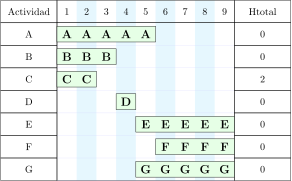

In [60]:
gantt, dibujo = proyecto.gantt(datos_proyecto,
                          'actual_duration',
                          'names',
                          total=None,
                          holguras=True,
                          tikz=True, 
                          params=dict(
                             period_width=0.7,
                             critical_background_color='white!90!green',
                              critical_text_color='black',
                              
                          ),
              )
pinta_tikz(dibujo)

Recalculamos las duraciones de las tareas del proyecto, las ya realizadas con su duración real, las comenzadas siguen a ritmo de lo realizado y las que aún no han comenzado se cree que se desarrollarán según lo planificado

In [61]:
datos_proyecto_actualizado = datos_proyecto.copy()

empezadas = datos_proyecto_actualizado['performed'] > 0
datos_proyecto_actualizado.loc[empezadas, 'duration']  = 100 * datos_proyecto.loc[empezadas, 'actual_duration'] / datos_proyecto.loc[empezadas, 'performed']
datos_proyecto_actualizado.loc[~empezadas, 'duration'] = datos_proyecto.loc[~empezadas, 'duration']

In [62]:
datos_proyecto_actualizado

,predecessors,b,m,a,BAC,cost_cap_duration,cap_duration,actual_duration,AC,performed,resources,duration,standard_deviation,variance,ucr
activity,,,,,,,,,,,,,,,
A,---,6,2.50,2,1600,1800,2,5,1800,100,5,5.0,0.666667,0.444444,200.0
B,---,4,3.00,2,2900,3100,1,3,3200,100,5,3.0,0.333333,0.111111,100.0
C,---,3,2.00,1,600,800,1,2,550,100,5,2.0,0.333333,0.111111,200.0
D,B,3,2.00,1,600,700,1,1,540,100,10,1.0,0.333333,0.111111,100.0
E,"D,C",7,5.00,3,1600,2200,2,5,750,50,5,10.0,0.666667,0.444444,200.0
F,"A,D,C",4,3.00,2,2000,2800,2,4,500,40,5,10.0,0.333333,0.111111,800.0
G,"D,C",6,1.25,1,600,700,1,5,200,50,10,10.0,0.833333,0.694444,100.0
H,"F,E,G",10,8.00,6,3500,4900,3,0,0,0,5,8.0,0.666667,0.444444,280.0
I,"E,G",8,7.00,6,3700,4300,4,0,0,0,5,7.0,0.333333,0.111111,200.0


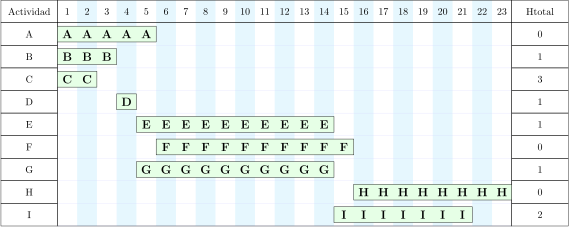

In [63]:
gantt, dibujo = proyecto.gantt(datos_proyecto_actualizado,
                          'duration',
                          'names',
                          total=None,
                          holguras=True,
                          tikz=True, 
                          params=dict(
                             period_width=0.7,
                             critical_background_color='white!90!green',
                              critical_text_color='black',
                              
                          ),
              )
pinta_tikz(dibujo)

##### Definimos un nuevo proyecto que consiste en las tareas (o parte de las tareas) que faltan por completar. Sobre este nuevo proyecto es sobre el que nos piden los cálculos.

In [64]:
datos_proyecto_simplificado = (datos_proyecto
                                  .query('performed != 100')
                                  .rename(columns={'duration':'durationBaseline'})
                                  .drop(['resources', 'standard_deviation', 'a', 'm', 'b', 'BAC', 'cost_cap_duration', 'AC'], axis=1)
                                  .copy()
                              )
datos_proyecto_simplificado['duration'] = datos_proyecto_simplificado['durationBaseline'] 

datos_proyecto_simplificado.loc[['E', 'F', 'G'], 'predecessors'] = '----'
datos_proyecto_simplificado.loc[['E', 'F', 'G'], 'cap_duration'] = 1
empezadas = datos_proyecto_simplificado['performed'] > 0
datos_proyecto_simplificado.loc[empezadas,:] = datos_proyecto_simplificado.eval('duration = (100 - performed) * actual_duration / performed')
#datos_proyecto_simplificado.drop(['actual_duration',  'performed'], axis=1, inplace=True)
datos_proyecto_simplificado

,predecessors,cap_duration,actual_duration,performed,durationBaseline,variance,ucr,duration
activity,,,,,,,,
E,----,1,5,50,5.0,0.444444,200.0,5.0
F,----,1,4,40,3.0,0.111111,800.0,6.0
G,----,1,5,50,2.0,0.694444,100.0,5.0
H,"F,E,G",3,0,0,8.0,0.444444,280.0,8.0
I,"E,G",4,0,0,7.0,0.111111,200.0,7.0


In [65]:
prelaciones_simplificado = PredecessorTable.from_dataframe_of_strings(datos_proyecto_simplificado, activity='activity', predecessor='predecessors')
proyecto_simplificado    = prelaciones_simplificado.create_project()

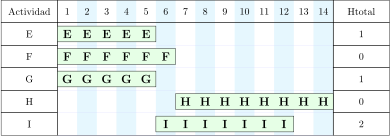

In [66]:
gantt, dibujo = proyecto.gantt(datos_proyecto_simplificado,
                          'duration',
                          'names',
                          total=None,
                          holguras=True,
                          tikz=True, 
                          params=dict(
                             period_width=0.7,
                             critical_background_color='white!90!green',
                              critical_text_color='black',
                              
                          ),
              )
pinta_tikz(dibujo)

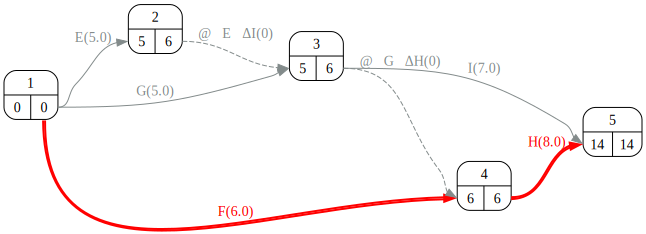

In [67]:
#| out-width: 100%
#| fig-cap: "Pert del resto del proyecto por completar"

proyecto_simplificado.pert(filename="pert_2.0.2_simplificado.pdf", durations=datos_proyecto_simplificado['duration'])

{{< pagebreak >}}

### Reducción de la duración del proyecto con mínimo incremento de coste: Ackoff y Sasieni de lo que falta por completar del proyecto

In [68]:
#| tab-width: 80%
#| tab-cap: "Algoritmo de Ackoff-Sassieni"

ackoff, best_option, duration, available = proyecto_simplificado.ackoff(durations     = datos_proyecto_simplificado['duration'],
                            min_durations = datos_proyecto_simplificado['cap_duration'],
                            costs         = datos_proyecto_simplificado['ucr'],
                            reduction=50
                            )

In [69]:
ackoff

,E,F,G,H,I,0,1,2,3,4,5,6,7,8,9
Route_1,200.0,,,280.0,,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0
Route_2,200.0,,,,200.0,12.0,12.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0
Route_3,,800.0,,280.0,,14.0,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0
Route_4,,,100.0,280.0,,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0
Route_5,,,100.0,,200.0,12.0,12.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0
0,4.0,5.0,4.0,5.0,3.0,,,,,,,,,,
1,4.0,5.0,4.0,4.0,3.0,,,,,,,,,,
2,4.0,5.0,4.0,3.0,3.0,,,,,,,,,,
3,4.0,5.0,4.0,2.0,2.0,,,,,,,,,,
4,4.0,5.0,4.0,1.0,1.0,,,,,,,,,,


{{< pagebreak >}}

{{< pagebreak >}}

### Montecarlo para lo que falta por completar del proyecto

In [70]:
num_of_samples = 3

names_of_the_tasks = datos_proyecto.index
np.random.seed(2025)
durations_montecarlo = pd.DataFrame([np.random.normal(size = num_of_samples,
                                                       loc  = datos_proyecto.duration[task],
                                                       scale= datos_proyecto.standard_deviation[task])
                                      for task in names_of_the_tasks],
                                     index=names_of_the_tasks).T.round(1)

In [71]:
durations_montecarlo

activity,A,B,C,D,E,F,G,H,I
0,2.9,2.8,2.5,2.1,4.3,2.4,1.9,7.9,7.0
1,3.5,3.0,1.9,1.7,4.9,3.4,1.7,7.9,7.3
2,2.0,3.7,2.3,1.7,5.1,3.0,3.3,8.5,7.0


#### Determinamos la matriz de caminos del proyecto.

In [72]:
proyecto = proyecto_simplificado.copy()
path_matrix = proyecto.path_matrix(dummies=False)
proyecto.display_path_matrix(dummies=False)

,E,F,G,H,I
Route_1,1,0,0,1,0
Route_2,1,0,0,0,1
Route_3,0,1,0,1,0
Route_4,0,0,1,1,0
Route_5,0,0,1,0,1


#### Cálculo de la duración del proyecto

In [73]:
datos_proyecto_restante = datos_proyecto.loc[path_matrix.columns,:]
restantes = datos_proyecto_restante.query('performed != 100')
durations_montecarlo = durations_montecarlo.reindex(restantes.index, axis=1)
durations_montecarlo = durations_montecarlo.eval('E = E * 0.5')
durations_montecarlo = durations_montecarlo.eval('F = F * 0.6')
durations_montecarlo = durations_montecarlo.eval('G = G * 0.5')
durations_montecarlo

,E,F,G,H,I
0,2.15,1.44,0.95,7.9,7.0
1,2.45,2.04,0.85,7.9,7.3
2,2.55,1.80,1.65,8.5,7.0


In [74]:
paths_durations_per_iteration = durations_montecarlo @ path_matrix.T
paths_durations_per_iteration

,Route_1,Route_2,Route_3,Route_4,Route_5
0,10.05,9.15,9.34,8.85,7.95
1,10.35,9.75,9.94,8.75,8.15
2,11.05,9.55,10.30,10.15,8.65


In [75]:
project_duration_per_iteration = paths_durations_per_iteration.max(axis="columns")
project_duration_per_iteration.T

0    10.05
1    10.35
2    11.05
dtype: float64

#### Determina la duración media y la desviación típica de la duración del proyecto.

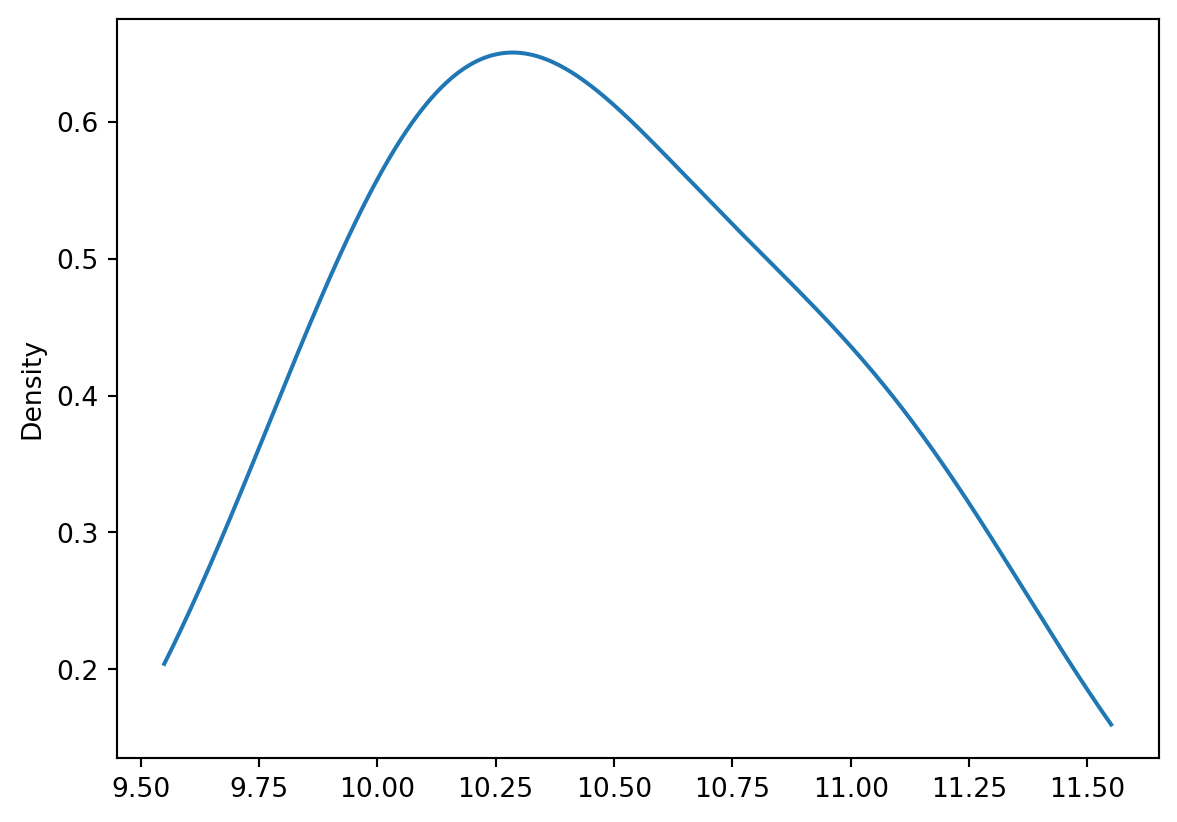

In [76]:
project_duration_per_iteration.plot(kind='density');

In [77]:
project_duration_per_iteration.describe()

count     3.000000
mean     10.483333
std       0.513160
min      10.050000
25%      10.200000
50%      10.350000
75%      10.700000
max      11.050000
dtype: float64

In [78]:
project_mean_duration = round(project_duration_per_iteration.mean(), 2)
project_std_deviation_duration = round(project_duration_per_iteration.std(), 2)

In [79]:
Markdown(f"La duración media del proyecto es: {project_mean_duration}, la desviación típica de la duración del proyecto es: {project_std_deviation_duration}")

La duración media del proyecto es: 10.48, la desviación típica de la duración del proyecto es: 0.51

#### ¿Cuál es la probabilidad de que el proyecto finalice en menos de 13 periodos de tiempo?

Utilizando la distribución normal

In [80]:
period = 10
probability = norm.cdf(period, loc=project_mean_duration, scale=project_std_deviation_duration)
Markdown(f"Para un proyecto con duración media {project_mean_duration} y desviación típica {round(project_std_deviation_duration, 2)} el valor de la probabilidad pedida es {round(probability * 100, 2)} por ciento.")

Para un proyecto con duración media 10.48 y desviación típica 0.51 el valor de la probabilidad pedida es 17.33 por ciento.

Utilizando los valores de Montecarlo

In [81]:
resultado = (project_duration_per_iteration <= period).mean()*100
Markdown(f"La probabilidad pedida es {resultado} por ciento")

La probabilidad pedida es 0.0 por ciento

#### ¿Cuál es la duración del proyecto para la cual podemos garantizar que el proyecto va finalizar antes de esa fecha con un 85% de probabilidad?

Utilizando la distribución normal

In [82]:
resultado = norm.ppf(0.85, loc=project_mean_duration, scale=project_std_deviation_duration)
Markdown(f"{resultado}")

11.008581028641833

Utilizando los valores de Montecarlo:

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 85% de las muestras.

In [83]:
resultado_1 = project_duration_per_iteration.sort_values(ascending=True).iloc[int(0.85*num_of_samples)]
Markdown(f"{resultado_1}")

11.05

O bien, utilizando la función `quantile`

In [84]:
resultado_2 = project_duration_per_iteration.quantile(q=0.85, interpolation='higher')
Markdown(f"{resultado_2}")

11.05